# Literature analysis for the WOA chapter: Ten Years of Self-organisation with Aggregate Computing: A Reflection Under the Lenses ofMulti-Agent Systems Engineering
This repository contains the code to reproduce tha charts presented in the chapter of the WOA book for the 25th year of the conference.
From this analysis, we can see the main topics related to aggregate computing (which are self-organisation, spatial computing, learning, coordination) are discussed over the years consistently. This analysis highlight also the topics which we used to structure the chapter.

In [225]:
import matplotlib.pyplot as plt
import pandas as pd
import litstudy
import json
import seaborn

from collections import namedtuple

from tensorflow.python.keras.metrics import cosine_similarity
from wordcloud import wordcloud

seaborn.set_style("whitegrid")
# Options for plots
plt.rcParams['figure.figsize'] = (10, 6)
## font size
plt.rcParams.update({'font.size': 20})
BibData = namedtuple("BibData", ["identifier", "title", "authors", "abstract", "publication_year"])
Author = namedtuple("Author", ["name"])

## Data Loading
In data.tsv we have the data given from the book chapter editors, which consist of the following columns:
- Authors: The authors of the paper
- Title: The title of the paper
- Abstract: The abstract of the paper
- Year: The year of the paper
- Discussed: If the paper was discussed in the chapter (filtered using the keywords `spatial`, `learning`, `autonomic`, `self-*`, `coordination`, `mult-agent`, `self-*` and with a manual review of the abstract, verifying if the paper was related to the topics of the chapter)

In [226]:
woa_papers = pd.read_csv("data.tsv", sep='\t')

## Filtering phase
As a first step, we filter WOA papers which contain the keywords related to aggregate computing. This is done by checking if the keywords are present in the title or in the abstract of the paper. The keywords are the following: spatial, learning, autonomic, self-*, coordination, multi-agent, runtime monitoring.

In [227]:
keywords = [
    "reinforcement learning",
    "machine learning",
    "adaptive",
    "coordination",
    "situated",
    "self",
    "programming",
    "interaction",
    "design",
    "bdi"
]
total = 0
## all is a set of all the papers which contains one of the keywords
all = set()
for keyword in keywords:
    papers = woa_papers[woa_papers['Title'].str.contains(keyword, case=False) | woa_papers['Abstract'].str.contains(keyword, case=False)]
    total += len(papers)
    all = all.union(set(papers['Title']))
len(all)

251

In [228]:
woa_papers = woa_papers[woa_papers['Discussed'] == 1.0]

In [229]:
woa_papers.head()

,Discussed,Authors,Title,Year,Abstract
0,1.0,Cherchi G.; Manconi A.; Vargiu E.; Deledda D.,"Text categorization using a Personalized, Adap...",2005,"In this paper, a multiagent system for support..."
7,1.0,Bandini S.; Manzoni S.; Redaelli S.,Towards the interpretation of emergent spatial...,2005,In this paper we present the preliminary resul...
11,1.0,Mascardi V.; Demergasso D.; Ancona D.,Languages for programming BDI-style agents: An...,2005,The notion of an intelligent agent as an entit...
12,1.0,Gardelli L.; Viroli M.; Omicini A.,On the role of simulation in the engineering o...,2005,The intrinsic complexity of self-organising mu...
14,1.0,Mamei M.; Zambonelli F.,Pervasive pheromone-based interaction with RFI...,2005,Despite the growing interest in pheromone-base...


This code convert the data to a format that can be used by the litstudy library, which is a list of BibData objects.
This object has the following fields:
- identifier: The identifier of the paper (title in this case, but it could be the DOI)
- title: The title of the paper 
- authors: A list of Author objects, which have a single field, name
- abstract: The abstract of the paper
- publication_year: The year of the paper

In [230]:
lit_study_compatible = []
for (id, element) in woa_papers.iterrows():
    authors = element['Authors'].split(';')
    authors = [Author(authors[i]) for i in range(len(authors))]
    data = BibData(element['Title'], element['Title'], authors, element['Abstract'], element['Year'])
    lit_study_compatible.append(data)
"Papers in the literature analysis:", len(lit_study_compatible)

('Papers in the literature analysis:', 64)

In order to perform the analysis, we need to filter the words that are not relevant to the analysis. This is done by loading the words_filter.json file, which contains a list of words that are not relevant to the analysis (i.e., common words like "application", "system", "model", etc).

In [231]:
# load word filter
with open("words_filter.json") as f:
    words_to_filter = json.load(f)

# Analysis
The analysis is performed in the following steps:
1. Build the corpus: This step creates a corpus from the data, removing the words that are not relevant and using n-grams to group similar words.
2. Plot the year histogram: This step plots the number of papers per year.
3. Plot the author histogram: This step plots the number of papers per author.
4. Compute the word distribution: This step computes the distribution of words in the corpus.
5. Plot the word distribution: This step plots the distribution of words in the corpus.
6. Compute the topic model: This step computes the topic model using NMF.
7. Plot the topic clouds: This step plots the topic clouds.

## Build the corpus

In [232]:
corpus = litstudy.build_corpus(
    lit_study_compatible, 
    ngram_threshold=0.8, 
    remove_words=words_to_filter,
)

## Plot the year histogram 
number of papers per year of self-organisation papers

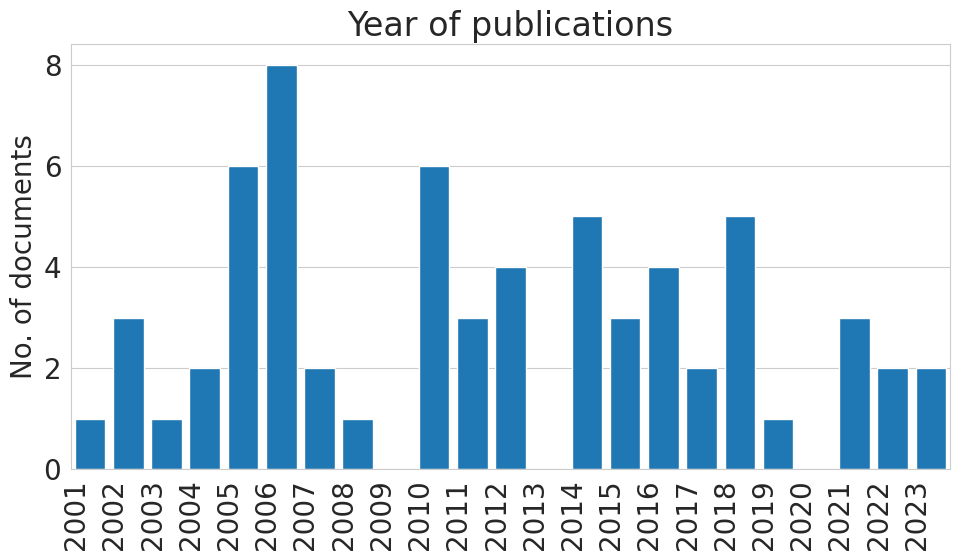

In [233]:
litstudy.plot_year_histogram(lit_study_compatible, vertical=True)
plt.tight_layout()
plt.savefig("images/year_histogram.pdf")

## Plot the author histogram
Number of papers per author

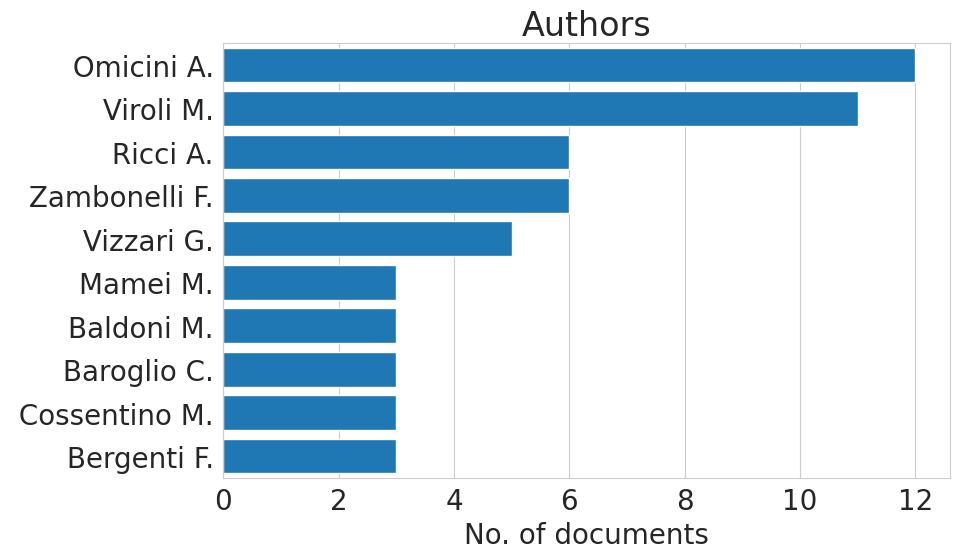

In [234]:
litstudy.plot_author_histogram(lit_study_compatible, limit=10, vertical=False)
plt.tight_layout()
plt.savefig("images/authors.pdf")

## Compute (and plotting) the word distribution 
Namely, how many times each word appears in the corpus 

In [235]:
litstudy.compute_word_distribution(corpus, limit=1000)

,count
adaptive,24
environment,23
coordination,23
interaction,20
multi,18
...,...
motivating,5
proper,5
decisions,5
runtime,5


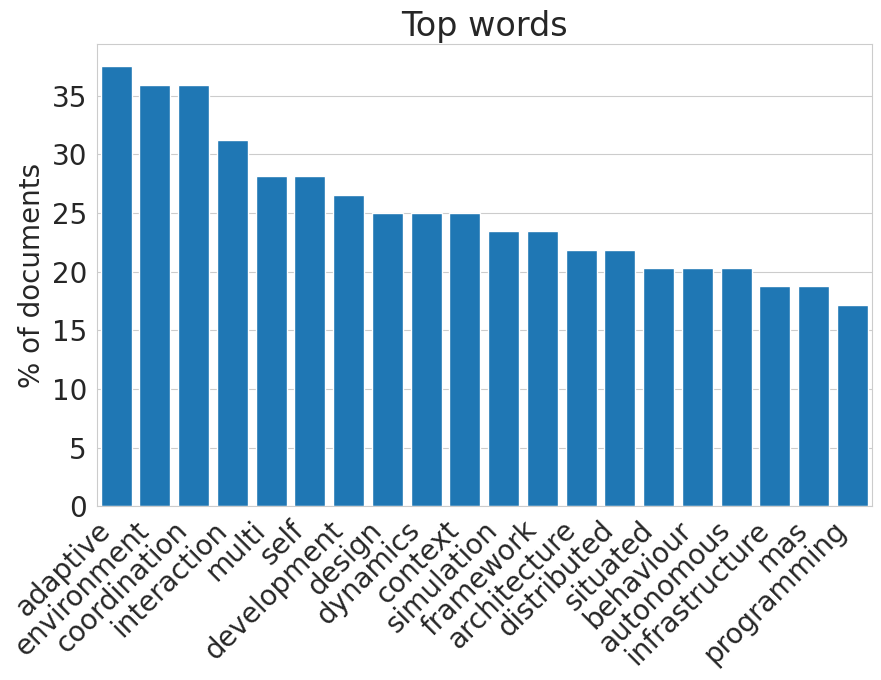

In [236]:
litstudy.plot_word_distribution(corpus, limit=20, title="Top words", vertical=True, label_rotation=45);
plt.savefig("images/top_words.pdf")

## Plot the word cloud
Namely, the most frequent words in the corpus. This is a visual representation of the word distribution.
The bigger the word, the more frequent it is in the corpus.

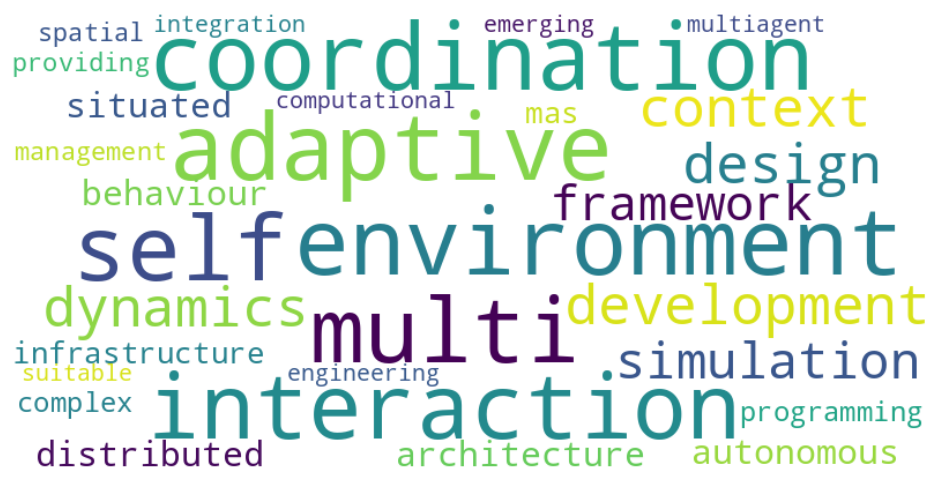

In [237]:
wc = wordcloud.WordCloud(
    prefer_horizontal=True,
    background_color='white',
    max_font_size=40,
    scale=2,
    relative_scaling=0.1,
)

words = litstudy.compute_word_distribution(corpus, limit=30)

frequencies = {}
for word, freq in words.iterrows():
    frequencies[word] = freq[0]
im = wc.generate_from_frequencies(frequencies)
plt.figure(figsize=(54, 6))
plt.imshow(im, interpolation='bilinear')
plt.axis('off')
plt.savefig("images/wordcloud.pdf")


## Topic Modelling with Gemini
To perform the topic modelling, we use the Gemini API, which is a generative model that can generate text based on a prompt. In this case, we use the prompt "You are an expert researcher in the fields of agents and learning. I will send you one paper and you will tell me which topic it belongs to. The topics are: - Self-* - Programming Agents - Coordination Protocol - Reinforcement Learning - Spatial Computing - Pervasive Computing - Knowledge Representation Or Reasoning If you do not know, reply with: - Multi-Agent Systems Applications Reply with just one topic."

In [238]:
import os
import google.generativeai as genai

genai.configure(api_key=os.environ["GENAI_API_KEY"])

# Create the model
generation_config = {
  "temperature": 0, "top_p": 0.95, "top_k": 40,
  "max_output_tokens": 8192,
  "response_mime_type": "text/plain",
}
prompt= """
You are an expert researcher in the fields of agents and learning.
I will send you one paper and you will tell me which topic it belongs to.
The topics are:
- Self-*
- Programming Agents
- Coordination Protocol 
- Reinforcement Learning
- Spatial Computing
- Pervasive Computing
- Knowledge Representation Or Reasoning
If you do not know, reply with:
- Multi-Agent Systems Applications
Reply with just one topic.
"""
model = genai.GenerativeModel(
  model_name="gemini-1.5-pro",
  system_instruction=prompt,
  generation_config=generation_config,
)
topics = []
for paper in lit_study_compatible:
    body = f"{paper.title} {paper.abstract}"    
    chat_session = model.start_chat(history=[])
    response = chat_session.send_message(content=body)
    print(paper.title + " --- " + response.text.strip())
    topics.append(response.text.strip())

Text categorization using a Personalized, Adaptive, and Cooperative MultiAgent System --- Multi-Agent Systems Applications
Towards the interpretation of emergent spatial patterns through Go game: The case of forest population dynamics --- Multi-Agent Systems Applications
Languages for programming BDI-style agents: An overview --- Programming Agents
On the role of simulation in the engineering of self-organising systems: Detecting abnormal behaviour in MAS --- Self-*
Pervasive pheromone-based interaction with RFID tags --- Pervasive Computing
A methodology for crowd modelling with Situated Cellular Agents --- Multi-Agent Systems Applications
Towards an agent model for future autonomic communications --- Self-*
A multidimensional flocking algorithm for clustering spatial data --- Spatial Computing
A repository of fragments for agent systems design --- Programming Agents
Minority Game: A logic-based approach in TuCSoN --- Coordination Protocol
Mechanisms of self-organization in pervasive 

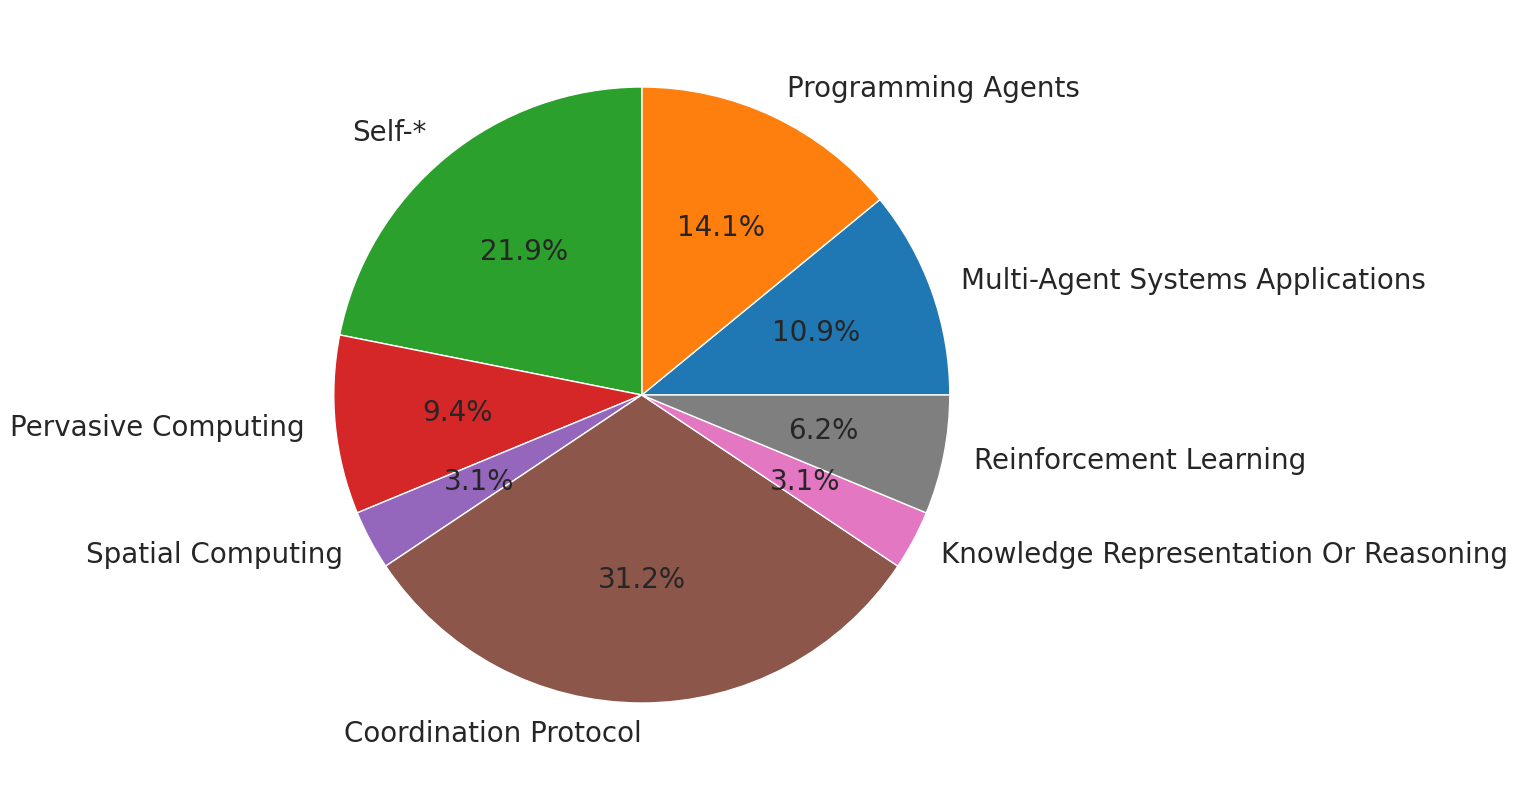

In [239]:
plt.rcParams.update({'font.size': 20})
plt.rcParams['figure.figsize'] = (25, 10)
# pie chart based on the topics
topics_count = {}
for topic in topics:
    if topic not in topics_count:
        topics_count[topic] = 0
    topics_count[topic] += 1
plt.pie(topics_count.values(), labels=topics_count.keys(), autopct='%1.1f%%')
plt.savefig("images/topics_pie.pdf")

In [240]:
# For each paper, extract, title - year - topic
# sort by year
papers_topics = []
for i in range(len(lit_study_compatible)):
    papers_topics.append((lit_study_compatible[i].title, lit_study_compatible[i].publication_year, topics[i]))
    
papers_topics.sort(key=lambda x: x[1])
papers_topics

[('Enlightened Agents in TuCSoN', 2001, 'Coordination Protocol'),
 ('Agent Coordination Contexts: Experiments in TuCSoN',
  2002,
  'Coordination Protocol'),
 ('Have ReSpecT for LogOp', 2002, 'Coordination Protocol'),
 ('Tuples on the Air: a Middleware for Context-Aware Multiagent Systems',
  2002,
  'Pervasive Computing'),
 ('Integrating Objective & Subjective Coordination in FIPA: A Roadmap to TuCSoN',
  2003,
  'Coordination Protocol'),
 ('Timed Coordination Artifacts with ReSpecT', 2004, 'Coordination Protocol'),
 ('Spatial Computing: The TOTA Approach', 2004, 'Spatial Computing'),
 ('Text categorization using a Personalized, Adaptive, and Cooperative MultiAgent System',
  2005,
  'Multi-Agent Systems Applications'),
 ('Towards the interpretation of emergent spatial patterns through Go game: The case of forest population dynamics',
  2005,
  'Multi-Agent Systems Applications'),
 ('Languages for programming BDI-style agents: An overview',
  2005,
  'Programming Agents'),
 ('On the r

In [243]:
# count the number of papers per topic
topics_count = {}
for topic in topics:
    if topic not in topics_count:
        topics_count[topic] = 0
    topics_count[topic] += 1
topics_count

{'Multi-Agent Systems Applications': 7,
 'Programming Agents': 9,
 'Self-*': 14,
 'Pervasive Computing': 6,
 'Spatial Computing': 2,
 'Coordination Protocol': 20,
 'Knowledge Representation Or Reasoning': 2,
 'Reinforcement Learning': 4}

In [246]:
# total number of paper per year
years = {}
for paper in papers_topics:
    if paper[1] not in years:
        years[paper[1]] = 0
    years[paper[1]] += 1
years

{2001: 1,
 2002: 3,
 2003: 1,
 2004: 2,
 2005: 6,
 2006: 8,
 2007: 2,
 2008: 1,
 2010: 6,
 2011: 3,
 2012: 4,
 2014: 5,
 2015: 3,
 2016: 4,
 2017: 2,
 2018: 5,
 2019: 1,
 2021: 3,
 2022: 2,
 2023: 2}